<a href="https://colab.research.google.com/github/doc-city/diveintocode-ml/blob/circleci-project-setup/Sprint23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras.layers import LSTM, Dense, Dropout, Embedding, SimpleRNN, GRU
from keras.models import Sequential
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.callbacks import EarlyStopping
import numpy as np
import pylab as plt

In [2]:
max_features = 10000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
17473536/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences


In [3]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


# SimpleRNN

In [4]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
callbacks = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, mode='auto')
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


print('Train...')

callbacks = [EarlyStopping(monitor="val_loss", min_delta=0, patience=0, verbose=0, mode="auto")]
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(x_test, y_test), callbacks=callbacks)


score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)


Build model...
Train...
Epoch 1/15
782/782 [==============================] - 8s 11ms/step - loss: 0.5404 - accuracy: 0.7264
Test score: 0.5403885841369629
Test accuracy: 0.7264000177383423


# GRU

In [5]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
callbacks = [EarlyStopping(monitor="val_loss", min_delta=0, patience=0, verbose=0, mode="auto")]
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(x_test, y_test), callbacks=callbacks)
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


Build model...
Train...
Epoch 1/15
782/782 [==============================] - 23s 30ms/step - loss: 0.3619 - accuracy: 0.8394
Test score: 0.3618948459625244
Test accuracy: 0.8393599987030029


# LSTM

In [6]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
callbacks = [EarlyStopping(monitor="val_loss", min_delta=0, patience=0, verbose=0, mode="auto")]
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(x_test, y_test), callbacks=callbacks)
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Epoch 1/15
782/782 [==============================] - 26s 33ms/step - loss: 0.3761 - accuracy: 0.8347
Test score: 0.376105397939682
Test accuracy: 0.8346800208091736


# ConvLSTM2D

Epoch 1/15
95/95 [==============================] - 179s 2s/step - loss: 0.8689 - val_loss: 0.6963


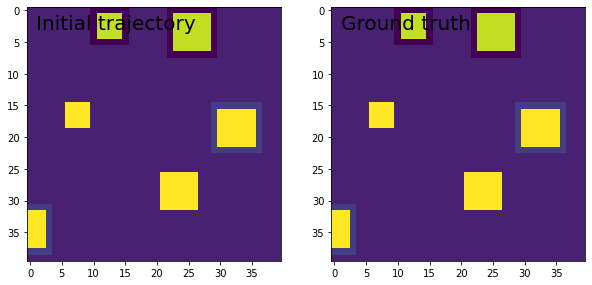

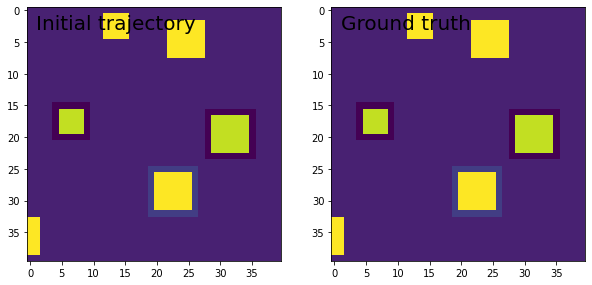

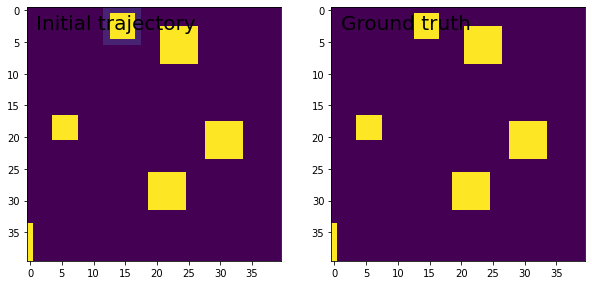

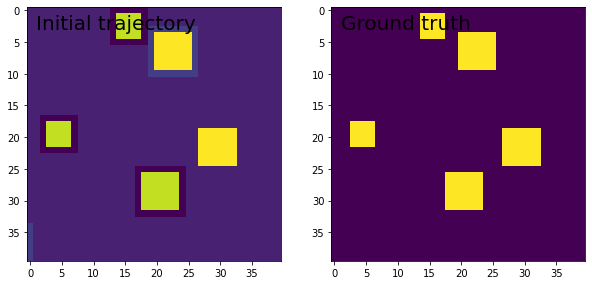

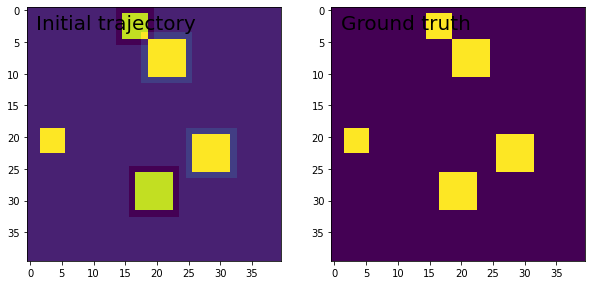

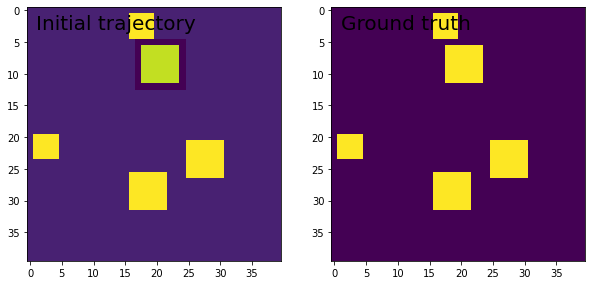

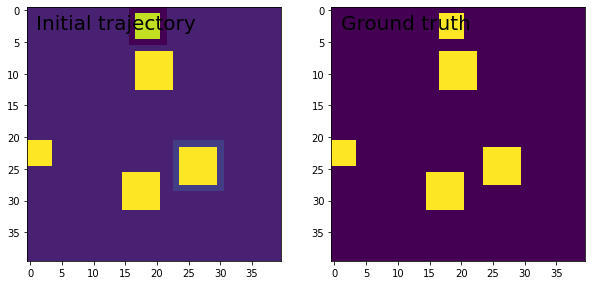

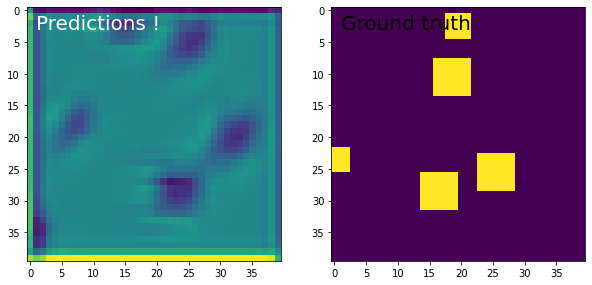

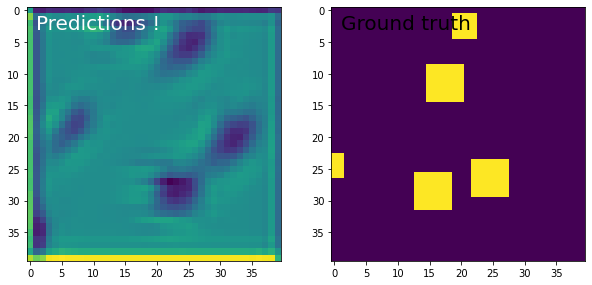

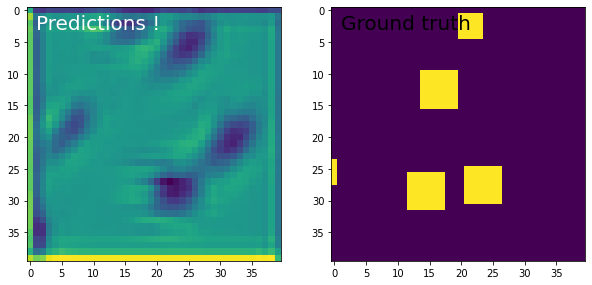

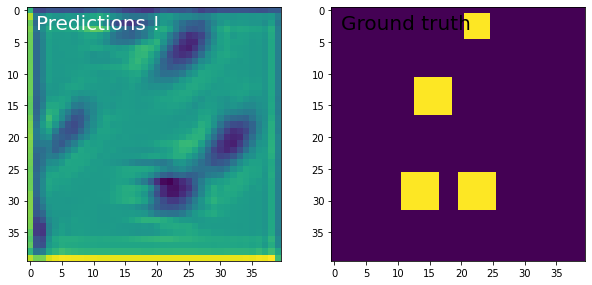

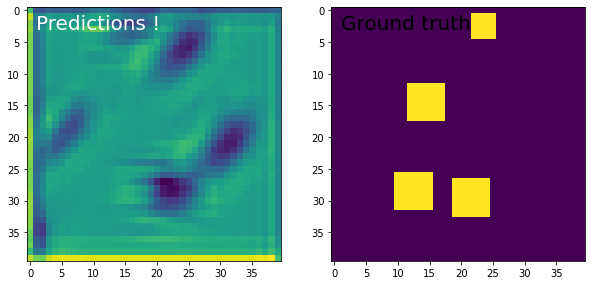

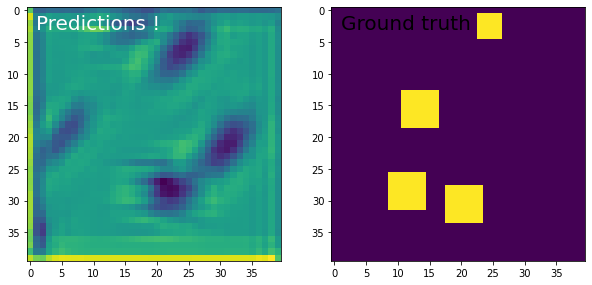

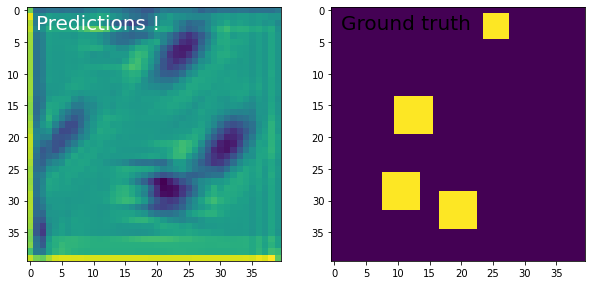

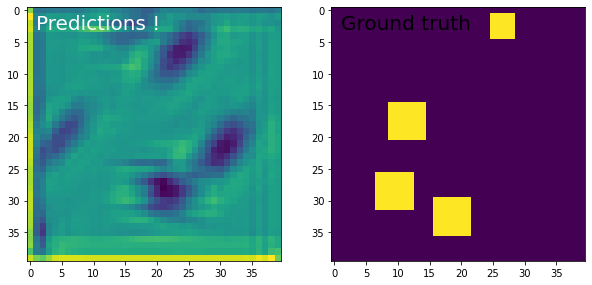

In [7]:
from keras.layers import BatchNormalization
seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 40, 40, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')


# Artificial data generation:
# Generate movies with 3 to 7 moving squares inside.
# The squares are of shape 1x1 or 2x2 pixels,
# which move linearly over time.
# For convenience we first create movies with bigger width and height (80x80)
# and at the end we select a 40x40 window.

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

# Train the network
noisy_movies, shifted_movies = generate_movies(n_samples=1200)
callbacks = [EarlyStopping(monitor="val_loss", min_delta=0, patience=0, verbose=0, mode="auto")]
seq.fit(noisy_movies[:1000], shifted_movies[:1000], batch_size=10, callbacks=callbacks,
        epochs=15, validation_split=0.05)

# Testing the network on one movie
# feed it with the first 7 positions and then
# predict the new positions
which = 1004
track = noisy_movies[which][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)


# And then compare the predictions
# to the ground truth
track2 = noisy_movies[which][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[which][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    plt.savefig('%i_animate.png' % (i + 1))


# Problem 3 Explanation of other classes

# RNN: A recurrent neural network (RNN) is a type of artificial neural network which uses sequential data or time series data. These deep learning algorithms are commonly used for ordinal or temporal problems, such as language translation, natural language processing (nlp), speech recognition, and image captioning; they are incorporated into popular applications such as Siri, voice search, and Google Translate. 

# SimpleRNNCell: Unlike RNN layers, which process the entire batch of input sequences, RNN cells process only a single time step. The cell is inside the for loop of the RNN layer.

# GRUCell: It is an alternative model to LSTM and requires less calculation than LSTM. Performance is said to be the same as LSTM.

# LSTMCell: You can learn long-term features and short-term features. The disadvantage is that it requires a lot of calculation.

# LSTMCell: You can learn long-term features and short-term features. The disadvantage is that it requires a lot of calculation.

# StackedRNNCells: A wrapper that makes the stack behavior of an RNN cell look like a single Cell. It is used to implement an efficient stacked RNN.


# CuDNNGRU: High-speed GRU implementation using CuDNN. It only works on the GPU with the TensorFlow backend.

# CuDNNLSTM: High-speed LSTM implementation using CuDNN. It only works on the GPU with the TensorFlow backend.